<a href="https://colab.research.google.com/github/rosiekwon/smart_healthcare/blob/main/WEEK%203/Neural_Net_%26_Back_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### affine layer

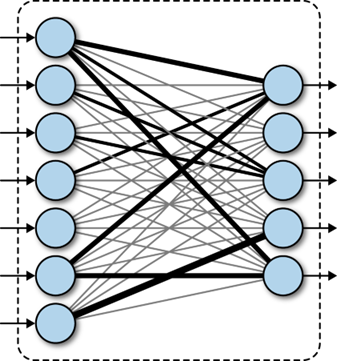

In [1]:
import numpy as np
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

##### softmax function

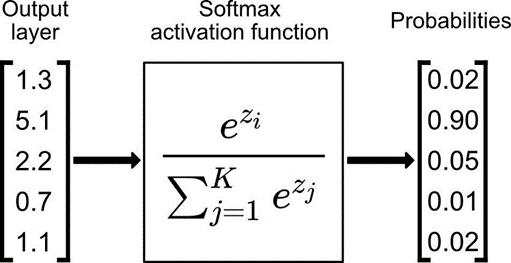

In [2]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x) # 지수함수 특성상 값이 급격히 커지는 오버플로우 방지
    return np.exp(x) / np.sum(np.exp(x))

##### relu function
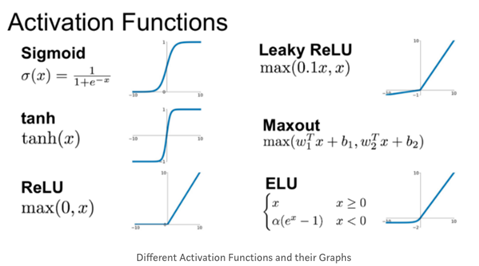

In [3]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

##### softmax with crossentropy error
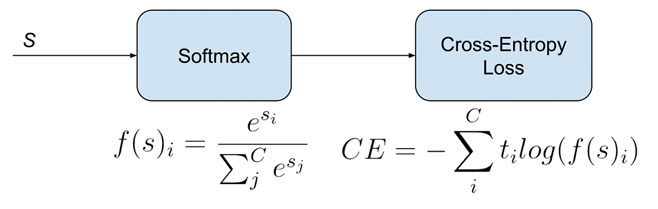

##### one-hot vector
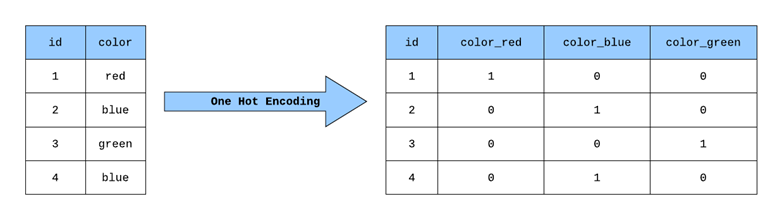

In [4]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

##### numerical_gradient
  - 편미분 :  여러 변수에 대한 함수의 편미분이라는 것은 여러 변수들 중 하나에 대해서 미분하고, 나머지는 상수로 취급하는 것을 의미한다.
  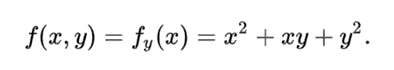
  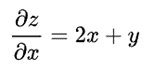
  - 수치미분
  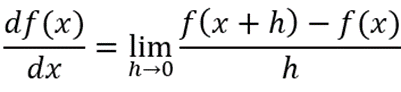

In [5]:
def numerical_gradient(f, x):
    h = 1e-6 # 0.000001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])  # np.nditer는 편미분
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [6]:
from collections import OrderedDict
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1']) 
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

##### mnist dataset
   - 사람의 손글씨를 그림파일로 만든 데이터 셋이다.
   - 0 ~ 9 까지의 클래스가 존재하며 총 60000개의 데이터가 존재한다.
   
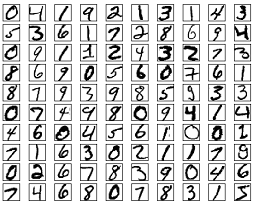

In [7]:
import tensorflow as tf

# 데이터 읽기
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data(path='minist.npz')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[55:75]
y_batch = y_train[55:75]

grad_numerical = network.numerical_gradient(x_batch, y_batch)
grad_backprop = network.gradient(x_batch, y_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:2.1699804831676638e-07
b1:4.338316944518074e-09
W2:2.313799025475371e-06
b2:2.3223419418484485e-07


In [10]:
iters_num = 10000 # 학습 횟수
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# [] <- python list
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) # 60000개 데이터셋에서 무작위 인덱싱 획득
    x_batch = x_train[batch_mask] # 데이터셋에서 무작위숫자로 
    t_batch = y_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.1303 0.1221
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135


In [11]:
train_loss_list ,train_acc_list, test_acc_list 

([13.378019373295405,
  12.894476500766658,
  2.30159227004784,
  2.298755425022932,
  2.300796568027718,
  2.300533333001538,
  2.3032655880139883,
  2.299614589613952,
  2.6639932010147085,
  2.298019778337449,
  2.3049968188333505,
  2.3026589256493146,
  2.3046030585478343,
  2.3021723236960097,
  2.3007335311687176,
  2.301867978655456,
  2.3037992388841912,
  2.298731061181126,
  2.29848730820419,
  2.3084754268968712,
  2.30461560074071,
  2.303752110800055,
  2.299810166639787,
  2.304561491112113,
  2.3001971290550114,
  2.3006560393714603,
  2.3065500822744864,
  2.301410892659357,
  2.3008811164897693,
  2.3075113246296444,
  2.308874809154758,
  2.297738844811338,
  2.3036572856702433,
  2.3034127810865193,
  2.297935778795235,
  2.3027235807207638,
  2.304239163309366,
  2.2990040499664173,
  2.299106998891956,
  2.294434409235058,
  2.3028003080763404,
  2.300462208190567,
  2.3000361362379014,
  2.3055091492190227,
  2.2977179682431617,
  2.2995675077225424,
  2.30227442